In [1]:
import os
import numpy as np
from os.path import join, expanduser
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
class ParseLine():
    def __init__(self, oneline, examples=False):        
        self.oneline = oneline.split('\t')
        if not examples:
            self.oneline = [self.oneline[0]] + [float(x) for x in self.oneline[1:]]
        else:
            if len(self.oneline)>1:
                self.oneline = [self.oneline[0]] + [float(x) for x in self.oneline[3:]+[self.oneline[2]]]
        
    @property
    def get_file(self):
        return self.oneline[0]
        
    @property
    def get_example(self):
        return self.oneline[4]
    
    @property
    def get_cb(self):
        return self.oneline[1]
        
    @property
    def get_igl(self):
        return self.oneline[2]
    
    @property
    def get_igl_inv(self):
        return self.oneline[3]

In [3]:
class ParseFile(ParseLine):
    def __init__(self, filename='results_file',with_examples=False):  
        self.with_examples = with_examples
        
        with open(filename, 'rb+') as f:
            lines = f.readlines()
        self.lines = [x.strip().decode() for x in lines  if not 'n.a.' in x.decode()]
        if with_examples:
            self.header = self.lines[:5]+[self.lines[-1]]
            self.lines = self.lines[5:-1]
            self.examples = []
        
        self.files = []
        self.cb_loss = []
        self.igl_loss = []
        self.igl_inv_loss = []
        
    def __call__(self):
        i=1
        for line in self.lines:
            i+=1
            thisline = ParseLine(line, self.with_examples)
            if len(thisline.oneline) <2 or 'n.a.' in thisline.oneline:
                continue
            self.files.append(thisline.get_file)
            self.cb_loss.append(thisline.get_cb)
            self.igl_loss.append(thisline.get_igl)
            self.igl_inv_loss.append(thisline.get_igl_inv)
            if self.with_examples:
                self.examples.append(thisline.get_example)
            #del thisline            

### Basic CDF

In [4]:
def cdf_plotter(ax, bin_edges, cb_cum, label='CB Loss CDF', linestyle='-.', color='blue'):
    ax.plot(bin_edges[1:], cb_cum, label=label, color=color, linestyle=linestyle, linewidth='4')
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0.15, 1.0])
    ax.set_ylim([0.05, 1.0])
    ax.set_title('CDF of 398 Datasets with $K>=3$', fontdict)
    ax.set_xlabel('Average loss,  $\ell$', fontdict=fontdict)
    ax.grid('on')
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.95),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='upper left', fontsize=20)

### DVH-Like Function for Progressive Val Loss Reporting

In [17]:
# leverage dose volume histogram plot used in medical physics
# see https://en.wikipedia.org/wiki/Dose-volume_histogram

def dvh_like(ax, data, label='CB Loss CDF', linestyle='-.', color='blue', title='CB vs IGL'):
    hist,bins = np.histogram(data,bins=500,range=(min(data), max(data)))
    temp = (100.-hist.cumsum()*100.0/len(data))
    ax.plot(bins[:-1],temp,label=label, color=color, linestyle=linestyle, linewidth='4')
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 100.5])
    ax.set_title(title, fontdict)
    ax.set_xlabel('Average loss,  $\ell=[0, 1]$', fontdict=fontdict)
    ax.grid('on') 
    ax.legend(fancybox=True, framealpha=0.5, #bbox_to_anchor=(0, 0.0),
                     borderaxespad=0., scatterpoints=1, ncol=1,
                     loc='lower left', fontsize=20)  
    

### Load Datasets and Define Global Variables

In [11]:
winsize =(16,6)
linewidth = 6
fig = plt.figure(figsize=winsize)
labelsize = 16
fontdict = {'fontsize':12, 'fontweight':'bold'}
colors = ['blue', 'red', 'yellow', 'orange', 'green', 'black']

## !!! Don't use this data; the losses were not flipped correctly during training !!! ##
incorrect_flipped_filename='notes/result_2021-08-13_01:43:00.dat'
pf = ParseFile(incorrect_flipped_filename)
pf()


## Retrained data w/correct flipping during training
filename='notes/result_2021-08-14_20:28:51.dat'
pfcorrect = ParseFile(filename, True)
pfcorrect()

# hist, bin_edges = np.histogram(pf.cb_loss, density=True)
# diff = bin_edges[1]-bin_edges[0]
# cb_cum = np.cumsum(hist)*diff

# hist_igl, bin_edges_igl = np.histogram(pf.igl_loss, density=True)
# diff_igl = bin_edges_igl[1]-bin_edges_igl[0]
# igl_cum = np.cumsum(hist_igl)*diff_igl

# hist_inv, bin_edges_inv = np.histogram(pf.igl_inv_loss, density=True)
# diff_inv = bin_edges_inv[1]-bin_edges_inv[0]
# inv_cum = np.cumsum(hist_igl)*diff_inv


# ax = fig.add_subplot(1, 2, 1)
# cdf_plotter(ax, bin_edges, cb_cum, label='CB Loss', linestyle='--', color=colors[0])
# cdf_plotter(ax, bin_edges_igl, igl_cum, label='IGL Loss', linestyle='-.', color=colors[1])
# ax.set_ylabel('Proportion of Datasets with loss < $\ell$', fontdict=fontdict)

# ax = fig.add_subplot(1, 2, 2)
# cdf_plotter(ax, bin_edges, cb_cum, label='CB Loss', linestyle='--', color=colors[0])
# cdf_plotter(ax, bin_edges_inv, inv_cum, label='IGL Flipped Loss', linestyle='-.', color=colors[1])

# fig.tight_layout()
# datetrained=incorrect_flipped_filename.split('/')[-1].split('_')
# datetrained = datetrained[1]+datetrained[-1].split('.')[0]

# fig.tight_layout()
# plt.savefig(f'notes/cdf_only_{datetrained}.jpg', dpi=79)
# plt.show()

<Figure size 1152x432 with 0 Axes>

### DVH-like plot for '2021-08-1301:43:00'

+ Don't use this data; the losses were not flipped correctly during training

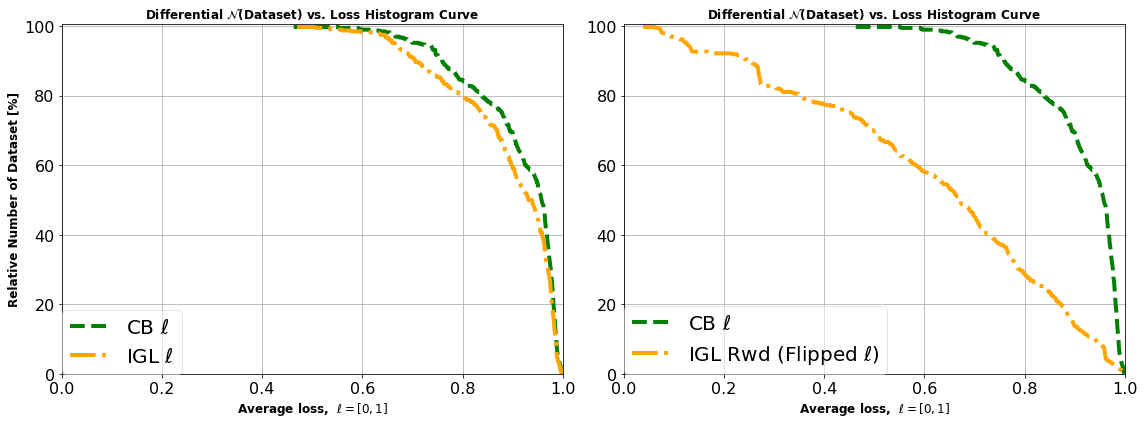

In [18]:
save=False
fig = plt.figure(figsize=winsize)
ax = fig.add_subplot(1, 2, 1)
dvh_like(ax, pf.cb_loss, label='CB $\ell$', linestyle='--', color=colors[4])
dvh_like(ax, pf.igl_loss, label='IGL $\ell$', linestyle='-.', color=colors[3], title='Differential $\mathcal{N}$(Dataset) vs. Loss Histogram Curve')
ax.set_ylabel('Relative Number of Dataset [%]', fontdict)

ax = fig.add_subplot(1, 2, 2)
dvh_like(ax, pf.cb_loss, label='CB $\ell$', linestyle='--', color=colors[4])
dvh_like(ax, pf.igl_inv_loss, label='IGL Rwd (Flipped $\ell$)', linestyle='-.', color=colors[3], title='Differential $\mathcal{N}$(Dataset) vs. Loss Histogram Curve')

datetrained=incorrect_flipped_filename.split('/')[-1].split('_')
datetrained = datetrained[1]+datetrained[-1].split('.')[0]

fig.tight_layout()
if save:
    plt.savefig(f'notes/igl_dvh_{datetrained}.jpg', dpi=79)
plt.show()

### DVH-Like Plot for notes/result_2021-08-14_20:28:51.dat

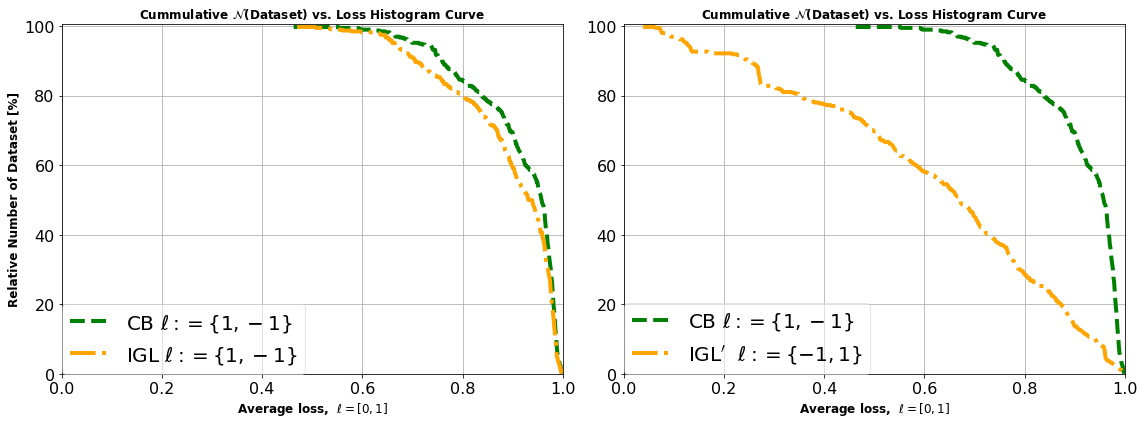

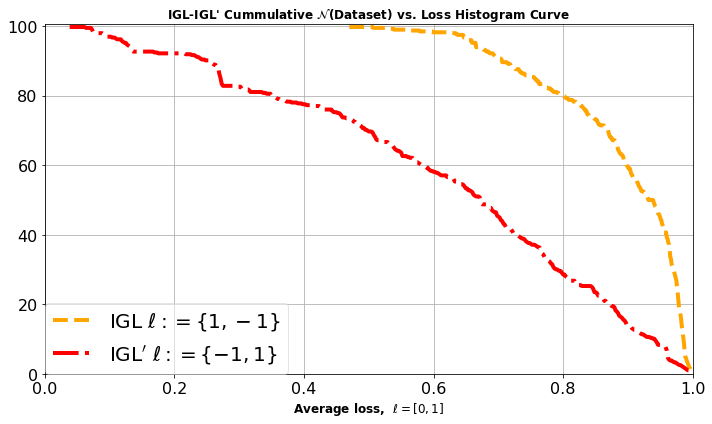

In [19]:
### August 14 Results
# leverage dose volume histogram plot in medical physics
# see https://en.wikipedia.org/wiki/Dose-volume_histogram

winsize=(16, 6)
fig = plt.figure(figsize=winsize)
ax = fig.add_subplot(1, 2, 1)
pf = pfcorrect
dvh_like(ax, pf.cb_loss, label='CB $\ell:=\{1, -1\}$', linestyle='--', color=colors[4])
dvh_like(ax, pf.igl_loss, label='IGL $\ell:=\{1, -1\}$', linestyle='-.', color=colors[3], title='Cummulative $\mathcal{N}$(Dataset) vs. Loss Histogram Curve')
ax.set_ylabel('Relative Number of Dataset [%]', fontdict)

ax = fig.add_subplot(1, 2, 2)
dvh_like(ax, pf.cb_loss, label='CB $\ell:=\{1, -1\}$', linestyle='--', color=colors[4])
dvh_like(ax, pf.igl_inv_loss, label='IGL$^\prime$  $\ell:=\{-1, 1\}$', linestyle='-.', color=colors[3], title='Cummulative $\mathcal{N}$(Dataset) vs. Loss Histogram Curve')

fig.tight_layout()

datetrained=filename.split('/')[-1].split('_')
datetrained = datetrained[1]+datetrained[-1].split('.')[0]

plt.savefig(f'notes/igl_dvh_{datetrained}.jpg', dpi=79)
plt.show()


# Now show just IGL and IGL Inverted alone
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
dvh_like(ax, pf.igl_loss, label='IGL $\ell:=\{1, -1\}$', linestyle='--', color=colors[3])
dvh_like(ax, pf.igl_inv_loss, label='IGL$^\prime$ $\ell:=\{-1, 1\}$', linestyle='-.', color=colors[1], \
         title='IGL-IGL\' Cummulative $\mathcal{N}$(Dataset) vs. Loss Histogram Curve')
fig.tight_layout()

datetrained=filename.split('/')[-1].split('_')
datetrained = datetrained[1]+datetrained[-1].split('.')[0]

plt.savefig(f'notes/igl_igl_inv_{datetrained}.jpg', dpi=79)
plt.show()